In [7]:

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
import pandas as pd
from gensim.models import Phrases
from gensim.models import Word2Vec
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from gensim.scripts import word2vec2tensor
from itertools import combinations

In [8]:
# For wordembedding we need to remove more stop words
def stopwords(text):
    if text not in ['since', 'if', 'because', 'yes', 'yet', 'although',
            'therefore', 'wherefore', 'albeit', 'howsoever']:
            return True

In [10]:
# Get the training corpus for bigram model
texts = []
textnames = []
folder = '/srv/data/EPTuningReplaced'
for file in os.listdir(folder):
    path = os.path.join(folder,file)
    f = open(path,'r')
    data = f.readlines()[0]
    texts.append(data)
    name = file.split('.')[0]
    textnames.append(name)
    f.close()

# list of lists of strings, each text broken up into individual token strings
tokenized = []
for text in texts:
    words = []
    text = text.split(' ')
    for t in text:
        if len(t) != 0 and stopwords(t):
            words.append(t)
    tokenized.append(words)



In [11]:
# Create bigram model based on training corpus
bigrammodel = Phrases(tokenized, min_count = 3, threshold=20)

In [13]:
# Create test corpus for the bigram model
test_texts = []
test_textnames = []
folder = '/srv/data/relevantEPBodyReplaced'
for file in os.listdir(folder):
        path = os.path.join(folder,file)
        f = open(path,'r')
        name = file.split('.')[0]
        if name not in textnames:
            test_textnames.append(name)
            data = f.readlines()[0]
            test_texts.append(data)
        f.close()


test = []
for text in test_texts:
    words = []
    text = text.split(' ')
    for t in text:
        if len(t) != 0 and stopwords(t):
            words.append(t)
    test.append(words)

In [14]:
# Create list for the word2vec model
all_sentences = []
for t in test_textnames:
    textindex = test_textnames.index(t)
    all_sentences.append(bigrammodel[test[textindex]])

In [15]:
# Creared word2vec model and store it
word2vec = Word2Vec(all_sentences, min_count=2, window=4)
word2vec.wv.save_word2vec_format('/srv/data/tensor/relevantep.model')
#word2vec.save('/srv/data/embedmodels/sermon.model')

In [16]:
# Check similarity for a specific word
print(word2vec.wv.most_similar("whoredom"))

[('fornication', 0.8600226640701294), ('adultery', 0.8020972609519958), ('incest', 0.7967420220375061), ('uncleanness', 0.7350381016731262), ('theft_murder', 0.7173861265182495), ('sodomy', 0.7142390012741089), ('murder_theft', 0.6969329714775085), ('incontinency', 0.6889588236808777), ('whordome', 0.6881306767463684), ('drunkenness', 0.666486382484436)]


In [17]:
#Create PCA table
pca = PCA(n_components=2)
pca_results = pca.fit_transform(word2vec.wv.get_normed_vectors())
pca_df = pd.DataFrame(pca_results, index=word2vec.wv.key_to_index, columns=["pc1","pc2"])
pca_df

,pc1,pc2
god,0.573091,-0.592934
man,0.658576,-0.505181
great,0.641312,-0.334408
see,0.692293,-0.395337
good,0.596301,-0.386141
...,...,...
framfield,0.412686,-0.104544
yoked,-0.149301,-0.160313
bvf,0.292320,-0.119310
byshoplyke,0.334869,-0.041147


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

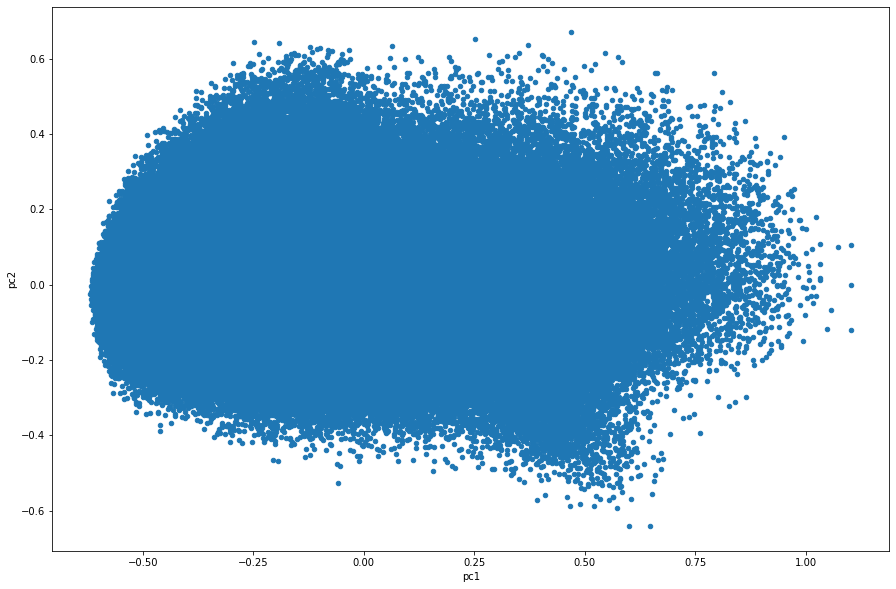

In [18]:
# Create PCA plots
pca_df.plot(x='pc1',y='pc2',kind="scatter",figsize=(15, 10))

In [19]:
# Create tsv file for word2vec model
word2vec2tensor.word2vec2tensor('/srv/data/tensor/relevantep.model', '/srv/data/tensor/TSV/relevantep', binary=False)

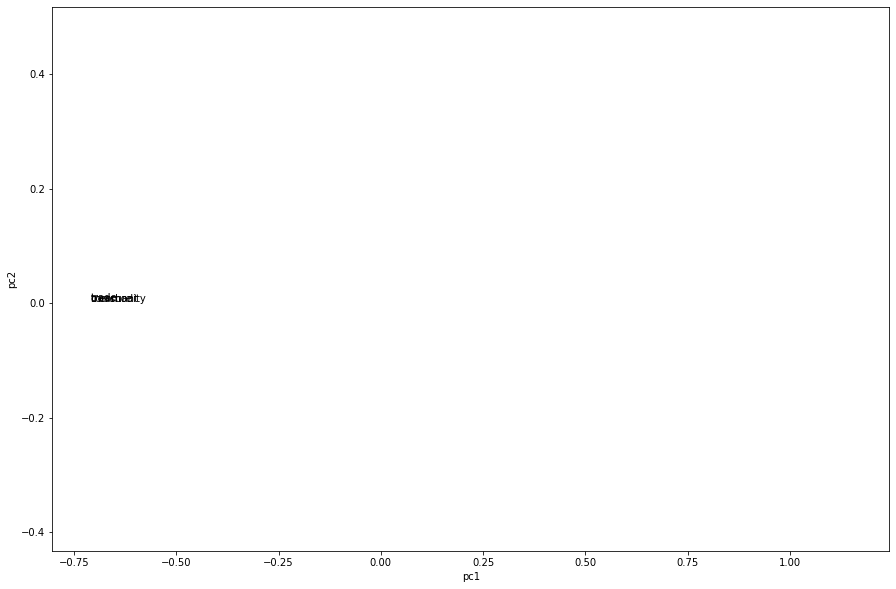

In [40]:
# Scatter plot with label
ax = pca_df.plot(x='pc1',y='pc2',kind="scatter",figsize=(15, 10),alpha=0)
for txt in pca_df.index:
    if txt in ["trade", "treasure", "commodity", "merchant"]:
        x = pca_df.pc1.loc[txt]
        y = pca_df.pc2.loc[txt]
        ax.annotate(txt, (x,y))
plt.show()

In [82]:
#Heatmap
vectors = word2vec.wv

def cosine_similarity(pair):

    '''
    Word2Vec.wv.similarity(word1,word2)
    '''
    word1, word2 = pair

    sim = vectors.similarity(word1,word2)

    return sim


def generate_heatmap_matrix(lexicon):

    pairs = list(combinations(lexicon, 2))

    sim_scores = [cosine_similarity(pair) for pair in pairs]

    sim_df = pd.DataFrame({'pair': pairs, 'similarity': sim_scores})

    sim_df['word1'] = sim_df['pair'].apply(lambda x: lexicon.index(x[0]))
    sim_df['word2'] = sim_df['pair'].apply(lambda x: lexicon.index(x[1]))

    sim_df['pair'] = list(zip(sim_df.word1, sim_df.word2, sim_df.similarity))

    df_hm = pd.DataFrame({'word1': range(len(lexicon)),
                          'word2': range(len(lexicon)),
                          'similarity': pd.Series(np.ones(len(lexicon)))})

    df_hm = df_hm.pivot(index='word1', columns='word2').fillna(0)

    for row, col, similarity in sim_df.pair:

        df_hm.iloc[col,row] = similarity

    return df_hm


def plot_heatmap(lexicon):

    df_hm = generate_heatmap_matrix(lexicon)

    mask = np.zeros_like(df_hm)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(df_hm,
                mask = mask,
                xticklabels = lexicon,
                yticklabels = lexicon,
                cmap="YlGnBu")
    plt.xlabel('word 1')
    plt.ylabel('word 2')
    plt.title(f'Similarity Between Word-Pairs')
    plt.show()





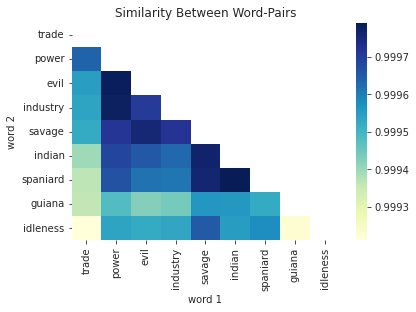

In [83]:
lexicon = ['trade','power','evil','industry', 'savage', 'indian', 'spaniard', 'guiana', 'idleness']

plot_heatmap(lexicon)